In [1]:
# Step 1: Import Essential Libraries for House Price Prediction
# This is our foundation - all the tools we'll need for data analysis and modeling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')  # Keep output clean during development

# Set up plotting style for better visualizations
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)  # Show all columns when needed

print("✅ All libraries imported successfully!")
print("Ready to start our house price prediction journey 🏠")

✅ All libraries imported successfully!
Ready to start our house price prediction journey 🏠


In [2]:
# Step 2: Load and Initial Data Exploration
# Time to meet our dataset and understand what we're working with

# Load the training data (make sure you've uploaded train.csv to Colab)
# If you haven't uploaded yet: Files > Upload > select train.csv
df = pd.read_csv('train.csv')

print("🎯 INITIAL DATA OVERVIEW")
print("=" * 50)
print(f"Dataset shape: {df.shape}")
print(f"We have {df.shape[0]} houses and {df.shape[1]} features to work with")
print()

print("📊 FIRST LOOK AT OUR DATA")
print("=" * 50)
print(df.head())
print()

print("🔍 DATA TYPES BREAKDOWN")
print("=" * 50)
print("Data types distribution:")
print(df.dtypes.value_counts())
print()

print("📈 TARGET VARIABLE (SalePrice) SUMMARY")
print("=" * 50)
print(df['SalePrice'].describe())
print()
print(f"Price range: ${df['SalePrice'].min():,.0f} to ${df['SalePrice'].max():,.0f}")
print(f"Average house price: ${df['SalePrice'].mean():,.0f}")

# Quick check for any obvious issues
print("\n🚨 QUICK HEALTH CHECK")
print("=" * 50)
print(f"Any duplicate rows? {df.duplicated().sum()}")
print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")

🎯 INITIAL DATA OVERVIEW
Dataset shape: (1460, 81)
We have 1460 houses and 81 features to work with

📊 FIRST LOOK AT OUR DATA
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  C

In [4]:
# Step 8: Handle Missing Values - Preprocessing
# Time to clean up our data and prepare it for modeling

print("🔧 HANDLING MISSING VALUES")
print("=" * 50)

# Make a copy of the original dataset for processing
df_processed = df.copy()
print(f"Starting with {df_processed.shape[0]} rows and {df_processed.shape[1]} columns")

# Analyze missing patterns more deeply first
missing_analysis = df_processed.isnull().sum().sort_values(ascending=False)
missing_features = missing_analysis[missing_analysis > 0]

print("Missing values strategy by feature type:")
print("=" * 40)

# Strategy 1: Features where NaN actually means "None" or "Not Applicable"
# Based on data description, these features have meaningful NaN values
none_features = {
    'PoolQC': 'No Pool',
    'MiscFeature': 'None',
    'Alley': 'No Alley',
    'Fence': 'No Fence',
    'FireplaceQu': 'No Fireplace',
    'GarageType': 'No Garage',
    'GarageFinish': 'No Garage',
    'GarageQual': 'No Garage',
    'GarageCond': 'No Garage',
    'BsmtQual': 'No Basement',
    'BsmtCond': 'No Basement',
    'BsmtExposure': 'No Basement',
    'BsmtFinType1': 'No Basement',
    'BsmtFinType2': 'No Basement',
    'MasVnrType': 'None'
}

print("1. Filling NaN with meaningful 'None' values:")
for feature, fill_value in none_features.items():
    if feature in df_processed.columns:
        before_count = df_processed[feature].isnull().sum()
        df_processed[feature].fillna(fill_value, inplace=True)
        print(f"   {feature}: {before_count} missing → filled with '{fill_value}'")

# Strategy 2: Numerical features where 0 makes sense for missing values
zero_features = {
    'GarageYrBlt': 0,  # No garage = year 0
    'GarageArea': 0,   # No garage = 0 area
    'GarageCars': 0,   # No garage = 0 cars
    'BsmtFinSF1': 0,   # No basement = 0 finished area
    'BsmtFinSF2': 0,   # No basement = 0 finished area
    'BsmtUnfSF': 0,    # No basement = 0 unfinished area
    'TotalBsmtSF': 0,  # No basement = 0 total area
    'BsmtFullBath': 0, # No basement = 0 full baths
    'BsmtHalfBath': 0, # No basement = 0 half baths
    'MasVnrArea': 0    # No masonry veneer = 0 area
}

print("\n2. Filling numerical NaN with 0 (where logical):")
for feature, fill_value in zero_features.items():
    if feature in df_processed.columns:
        before_count = df_processed[feature].isnull().sum()
        df_processed[feature].fillna(fill_value, inplace=True)
        print(f"   {feature}: {before_count} missing → filled with {fill_value}")

# Strategy 3: Use mode for remaining categorical features
print("\n3. Filling categorical features with mode:")
categorical_features = df_processed.select_dtypes(include=['object']).columns
for feature in categorical_features:
    if df_processed[feature].isnull().sum() > 0:
        mode_value = df_processed[feature].mode()[0] if len(df_processed[feature].mode()) > 0 else 'Unknown'
        before_count = df_processed[feature].isnull().sum()
        df_processed[feature].fillna(mode_value, inplace=True)
        print(f"   {feature}: {before_count} missing → filled with '{mode_value}'")

# Strategy 4: Use median for remaining numerical features
print("\n4. Filling numerical features with median:")
numerical_features = df_processed.select_dtypes(include=[np.number]).columns
for feature in numerical_features:
    if df_processed[feature].isnull().sum() > 0:
        median_value = df_processed[feature].median()
        before_count = df_processed[feature].isnull().sum()
        df_processed[feature].fillna(median_value, inplace=True)
        print(f"   {feature}: {before_count} missing → filled with {median_value}")

# Verify all missing values are handled
remaining_missing = df_processed.isnull().sum().sum()
print(f"\n✅ MISSING VALUES HANDLING COMPLETE!")
print(f"Remaining missing values: {remaining_missing}")

if remaining_missing == 0:
    print("🎉 Perfect! All missing values have been successfully handled.")
else:
    print(f"⚠️ Warning: {remaining_missing} missing values still remain.")
    remaining_features = df_processed.isnull().sum()
    remaining_features = remaining_features[remaining_features > 0]
    print("Features still with missing values:")
    print(remaining_features)

print(f"\nDataset shape after missing value handling: {df_processed.shape}")
print("Ready for feature encoding! 🚀")

🔧 HANDLING MISSING VALUES
Starting with 1460 rows and 81 columns
Missing values strategy by feature type:
1. Filling NaN with meaningful 'None' values:
   PoolQC: 1453 missing → filled with 'No Pool'
   MiscFeature: 1406 missing → filled with 'None'
   Alley: 1369 missing → filled with 'No Alley'
   Fence: 1179 missing → filled with 'No Fence'
   FireplaceQu: 690 missing → filled with 'No Fireplace'
   GarageType: 81 missing → filled with 'No Garage'
   GarageFinish: 81 missing → filled with 'No Garage'
   GarageQual: 81 missing → filled with 'No Garage'
   GarageCond: 81 missing → filled with 'No Garage'
   BsmtQual: 37 missing → filled with 'No Basement'
   BsmtCond: 37 missing → filled with 'No Basement'
   BsmtExposure: 38 missing → filled with 'No Basement'
   BsmtFinType1: 37 missing → filled with 'No Basement'
   BsmtFinType2: 38 missing → filled with 'No Basement'
   MasVnrType: 872 missing → filled with 'None'

2. Filling numerical NaN with 0 (where logical):
   GarageYrBlt: 8

📊 FEATURE DISTRIBUTION ANALYSIS
📈 Numerical features: 36
📝 Categorical features: 43



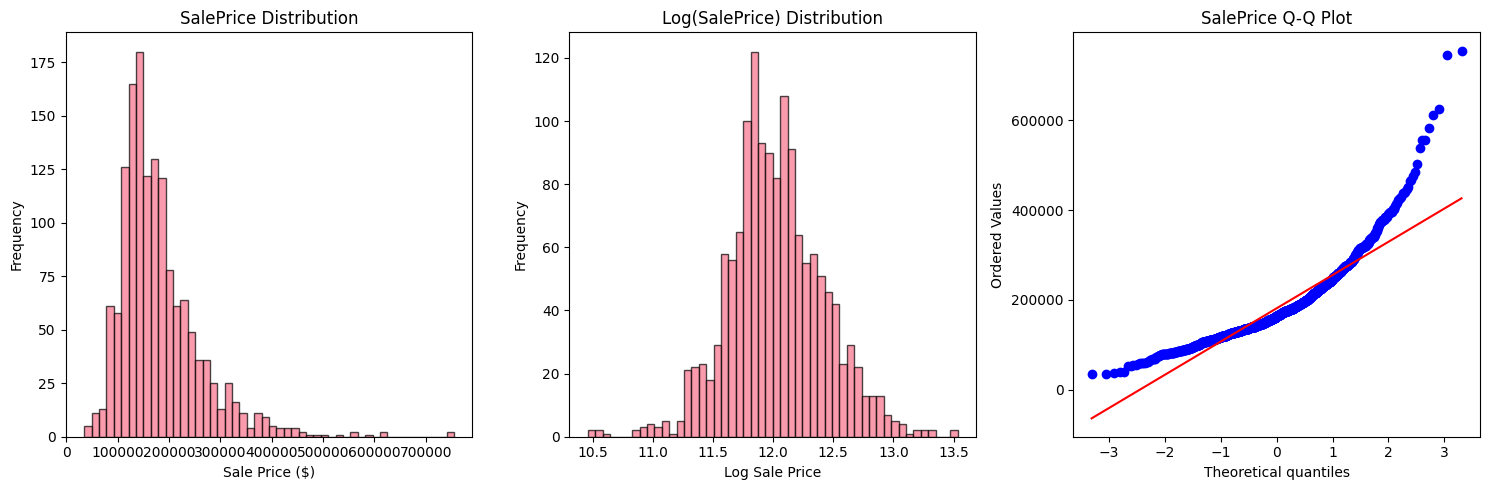

SalePrice skewness: 1.883
Note: Skewness > 1 indicates highly right-skewed distribution
We might need log transformation for our target variable

🔢 NUMERICAL FEATURES ANALYSIS
Basic statistics for key numerical features:
             LotArea    YearBuilt  TotalBsmtSF    GrLivArea   GarageCars  \
count    1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean    10516.828082  1971.267808  1057.429452  1515.463699     1.767123   
std      9981.264932    30.202904   438.705324   525.480383     0.747315   
min      1300.000000  1872.000000     0.000000   334.000000     0.000000   
25%      7553.500000  1954.000000   795.750000  1129.500000     1.000000   
50%      9478.500000  1973.000000   991.500000  1464.000000     2.000000   
75%     11601.500000  2000.000000  1298.250000  1776.750000     2.000000   
max    215245.000000  2010.000000  6110.000000  5642.000000     4.000000   

        GarageArea  
count  1460.000000  
mean    472.980137  
std     213.804841  
min       

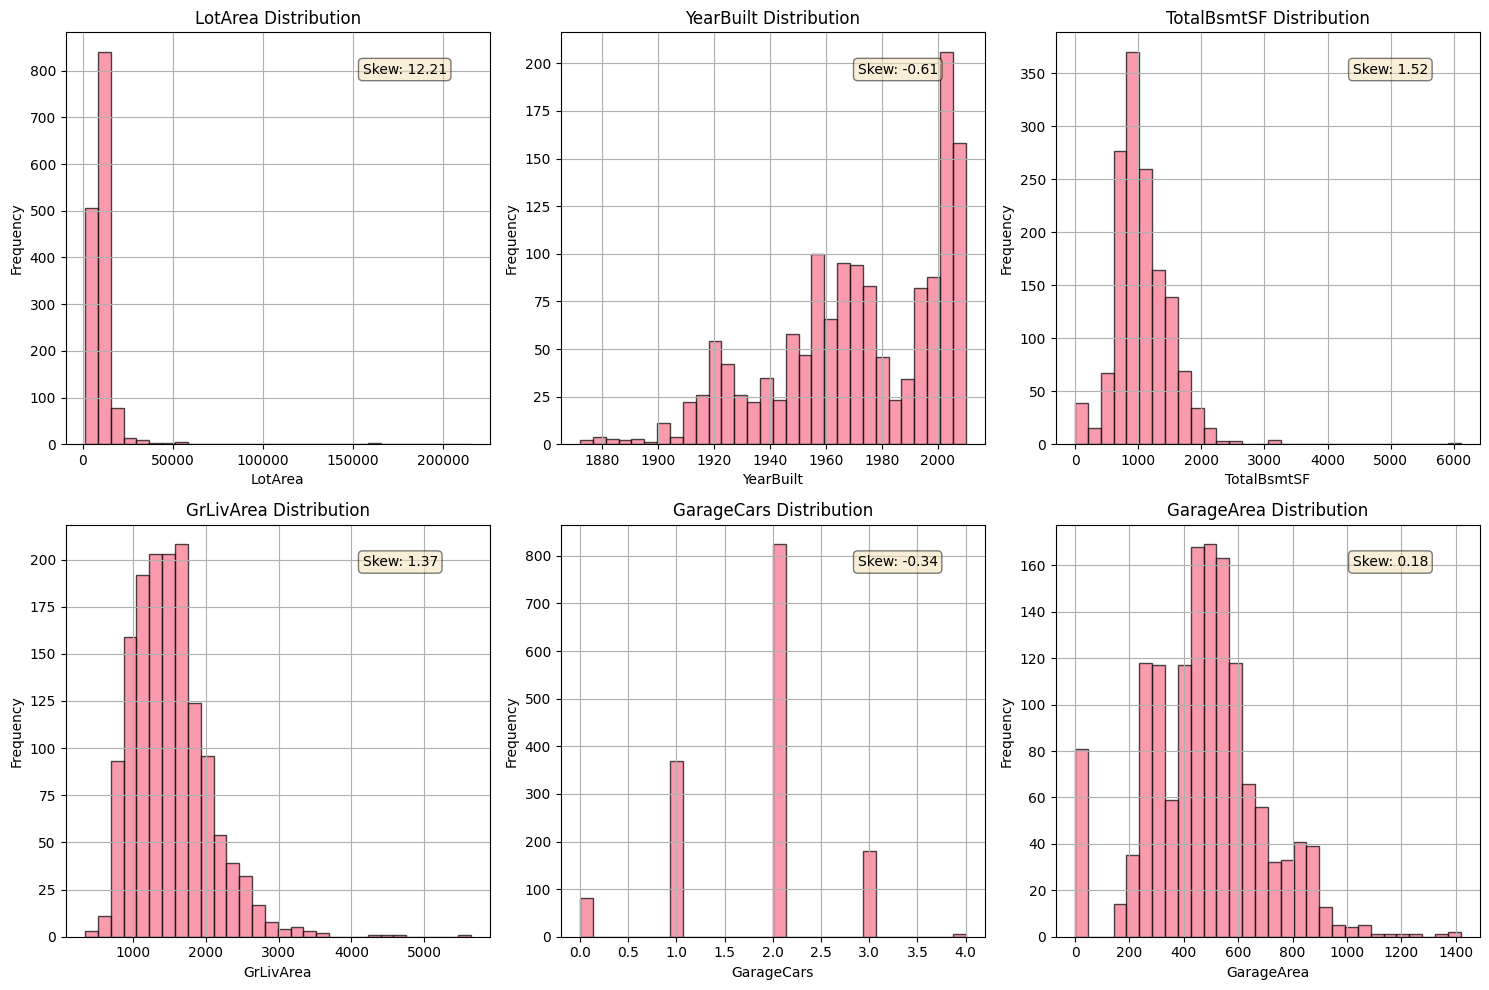

In [5]:
# Step 4: Feature Distribution Analysis
# Understanding how our features are distributed will guide our preprocessing decisions

print("📊 FEATURE DISTRIBUTION ANALYSIS")
print("=" * 50)

# Separate numerical and categorical features
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Remove Id from numerical (it's not really a feature) and SalePrice (our target)
numerical_features.remove('Id')
if 'SalePrice' in numerical_features:
    numerical_features.remove('SalePrice')

print(f"📈 Numerical features: {len(numerical_features)}")
print(f"📝 Categorical features: {len(categorical_features)}")
print()

# Analyze target variable distribution first
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df['SalePrice'], bins=50, edgecolor='black', alpha=0.7)
plt.title('SalePrice Distribution')
plt.xlabel('Sale Price ($)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(np.log(df['SalePrice']), bins=50, edgecolor='black', alpha=0.7)
plt.title('Log(SalePrice) Distribution')
plt.xlabel('Log Sale Price')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
from scipy import stats
stats.probplot(df['SalePrice'], dist="norm", plot=plt)
plt.title('SalePrice Q-Q Plot')

plt.tight_layout()
plt.show()

# Check skewness of target variable
skewness = df['SalePrice'].skew()
print(f"SalePrice skewness: {skewness:.3f}")
print("Note: Skewness > 1 indicates highly right-skewed distribution")
print("We might need log transformation for our target variable")
print()

# Analyze numerical features distributions
print("🔢 NUMERICAL FEATURES ANALYSIS")
print("=" * 50)

# Get basic stats for numerical features
print("Basic statistics for key numerical features:")
key_numerical = ['LotArea', 'YearBuilt', 'TotalBsmtSF', 'GrLivArea', 'GarageCars', 'GarageArea']
print(df[key_numerical].describe())

# Plot distributions of key numerical features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_numerical, 1):
    plt.subplot(2, 3, i)
    df[feature].hist(bins=30, edgecolor='black', alpha=0.7)
    plt.title(f'{feature} Distribution')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    # Add skewness info
    skew = df[feature].skew()
    plt.text(0.7, 0.9, f'Skew: {skew:.2f}', transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

🔗 CORRELATION ANALYSIS WITH SALEPRICE
Top 15 features most positively correlated with SalePrice:
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
Name: SalePrice, dtype: float64

Top 10 features most negatively correlated with SalePrice:
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64



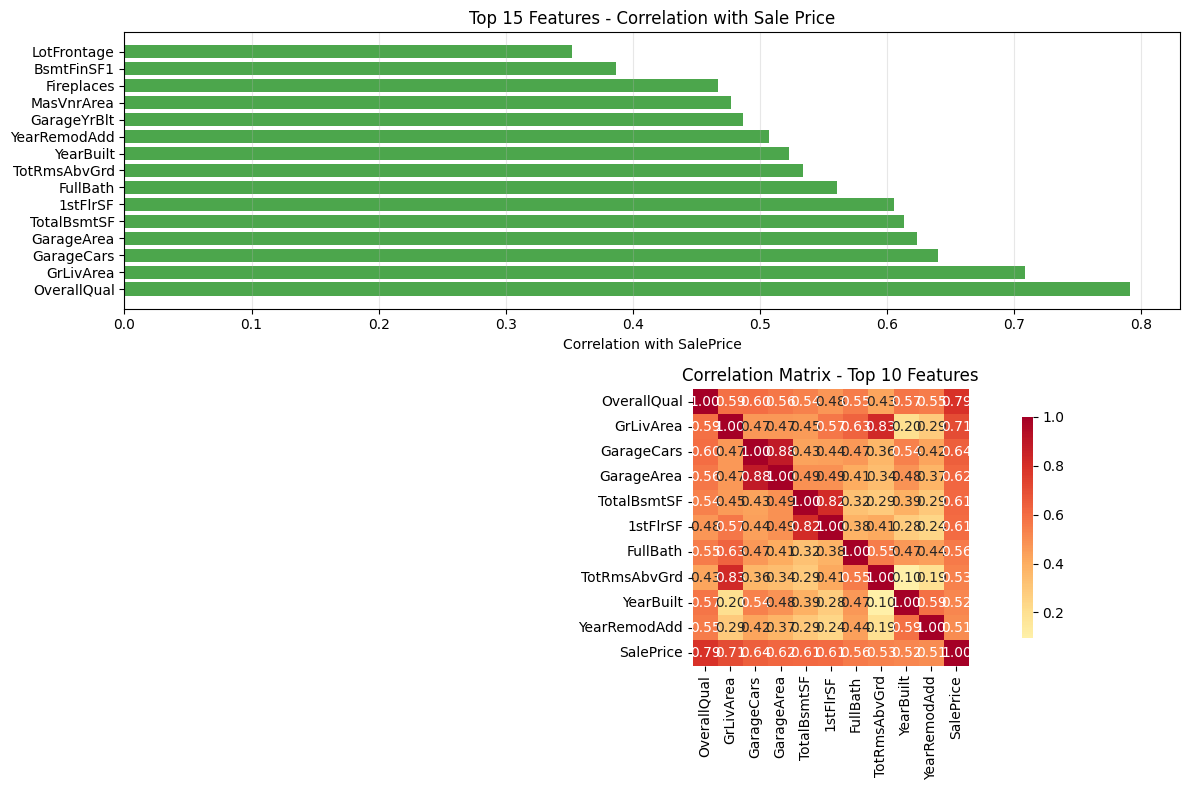

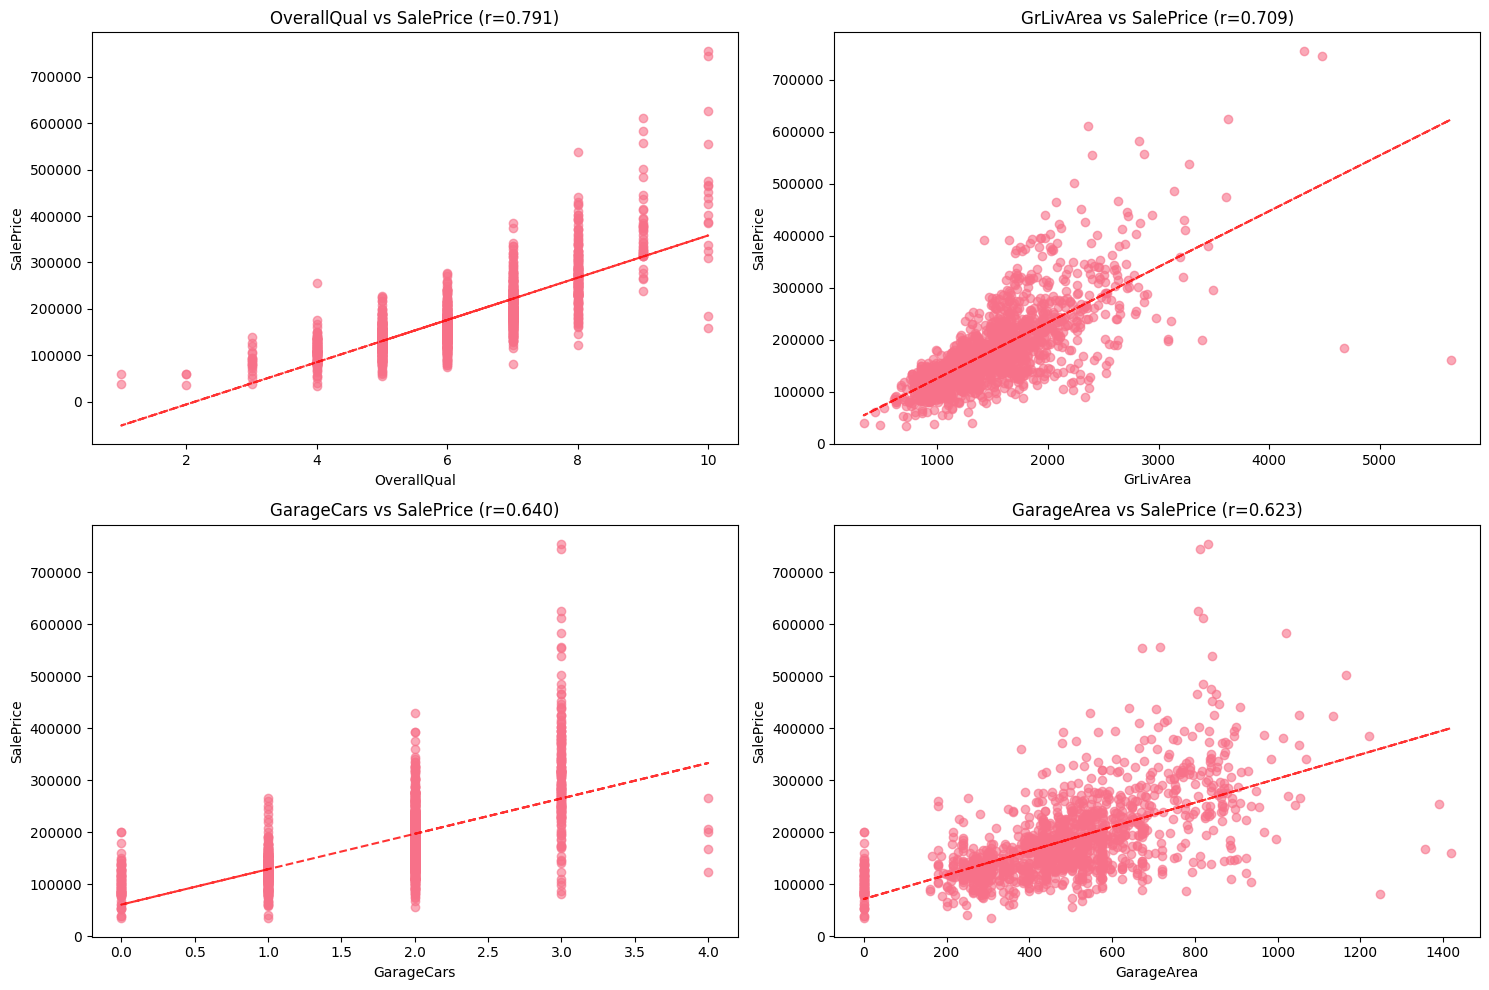

🚨 CHECKING FOR MULTICOLLINEARITY
High correlation pairs (>0.8) - potential multicollinearity:
GrLivArea <-> TotRmsAbvGrd: 0.825
GarageCars <-> GarageArea: 0.882
TotalBsmtSF <-> 1stFlrSF: 0.820


In [6]:
# Step 5: Correlation Analysis with Target Variable
# Finding which features have the strongest relationship with house prices

print("🔗 CORRELATION ANALYSIS WITH SALEPRICE")
print("=" * 50)

# Calculate correlations with SalePrice for numerical features
numeric_df = df.select_dtypes(include=[np.number])
correlations = numeric_df.corr()['SalePrice'].sort_values(ascending=False)

# Remove SalePrice correlation with itself
correlations = correlations.drop('SalePrice')

print("Top 15 features most positively correlated with SalePrice:")
print(correlations.head(15))
print()

print("Top 10 features most negatively correlated with SalePrice:")
print(correlations.tail(10))
print()

# Visualize top correlations
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
top_corrs = correlations.head(15)
colors = ['green' if x > 0 else 'red' for x in top_corrs.values]
plt.barh(range(len(top_corrs)), top_corrs.values, color=colors, alpha=0.7)
plt.yticks(range(len(top_corrs)), top_corrs.index)
plt.xlabel('Correlation with SalePrice')
plt.title('Top 15 Features - Correlation with Sale Price')
plt.grid(axis='x', alpha=0.3)

# Correlation heatmap for top correlated features
plt.subplot(2, 1, 2)
top_features = top_corrs.head(10).index.tolist() + ['SalePrice']
corr_matrix = df[top_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix - Top 10 Features')
plt.tight_layout()
plt.show()

# Scatter plots for top correlated features
plt.figure(figsize=(15, 10))
top_4_features = correlations.head(4).index.tolist()

for i, feature in enumerate(top_4_features, 1):
    plt.subplot(2, 2, i)
    plt.scatter(df[feature], df['SalePrice'], alpha=0.6)
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.title(f'{feature} vs SalePrice (r={correlations[feature]:.3f})')

    # Add trend line
    z = np.polyfit(df[feature].dropna(), df['SalePrice'][df[feature].notna()], 1)
    p = np.poly1d(z)
    plt.plot(df[feature].dropna(), p(df[feature].dropna()), "r--", alpha=0.8)

plt.tight_layout()
plt.show()

# Identify potential multicollinearity issues
print("🚨 CHECKING FOR MULTICOLLINEARITY")
print("=" * 50)
high_corr_pairs = []
for i in range(len(top_features)-1):
    for j in range(i+1, len(top_features)-1):  # Exclude SalePrice
        corr_val = corr_matrix.loc[top_features[i], top_features[j]]
        if abs(corr_val) > 0.8:  # High correlation threshold
            high_corr_pairs.append((top_features[i], top_features[j], corr_val))

if high_corr_pairs:
    print("High correlation pairs (>0.8) - potential multicollinearity:")
    for pair in high_corr_pairs:
        print(f"{pair[0]} <-> {pair[1]}: {pair[2]:.3f}")
else:
    print("✅ No severe multicollinearity detected among top features")

🎯 OUTLIER DETECTION ANALYSIS


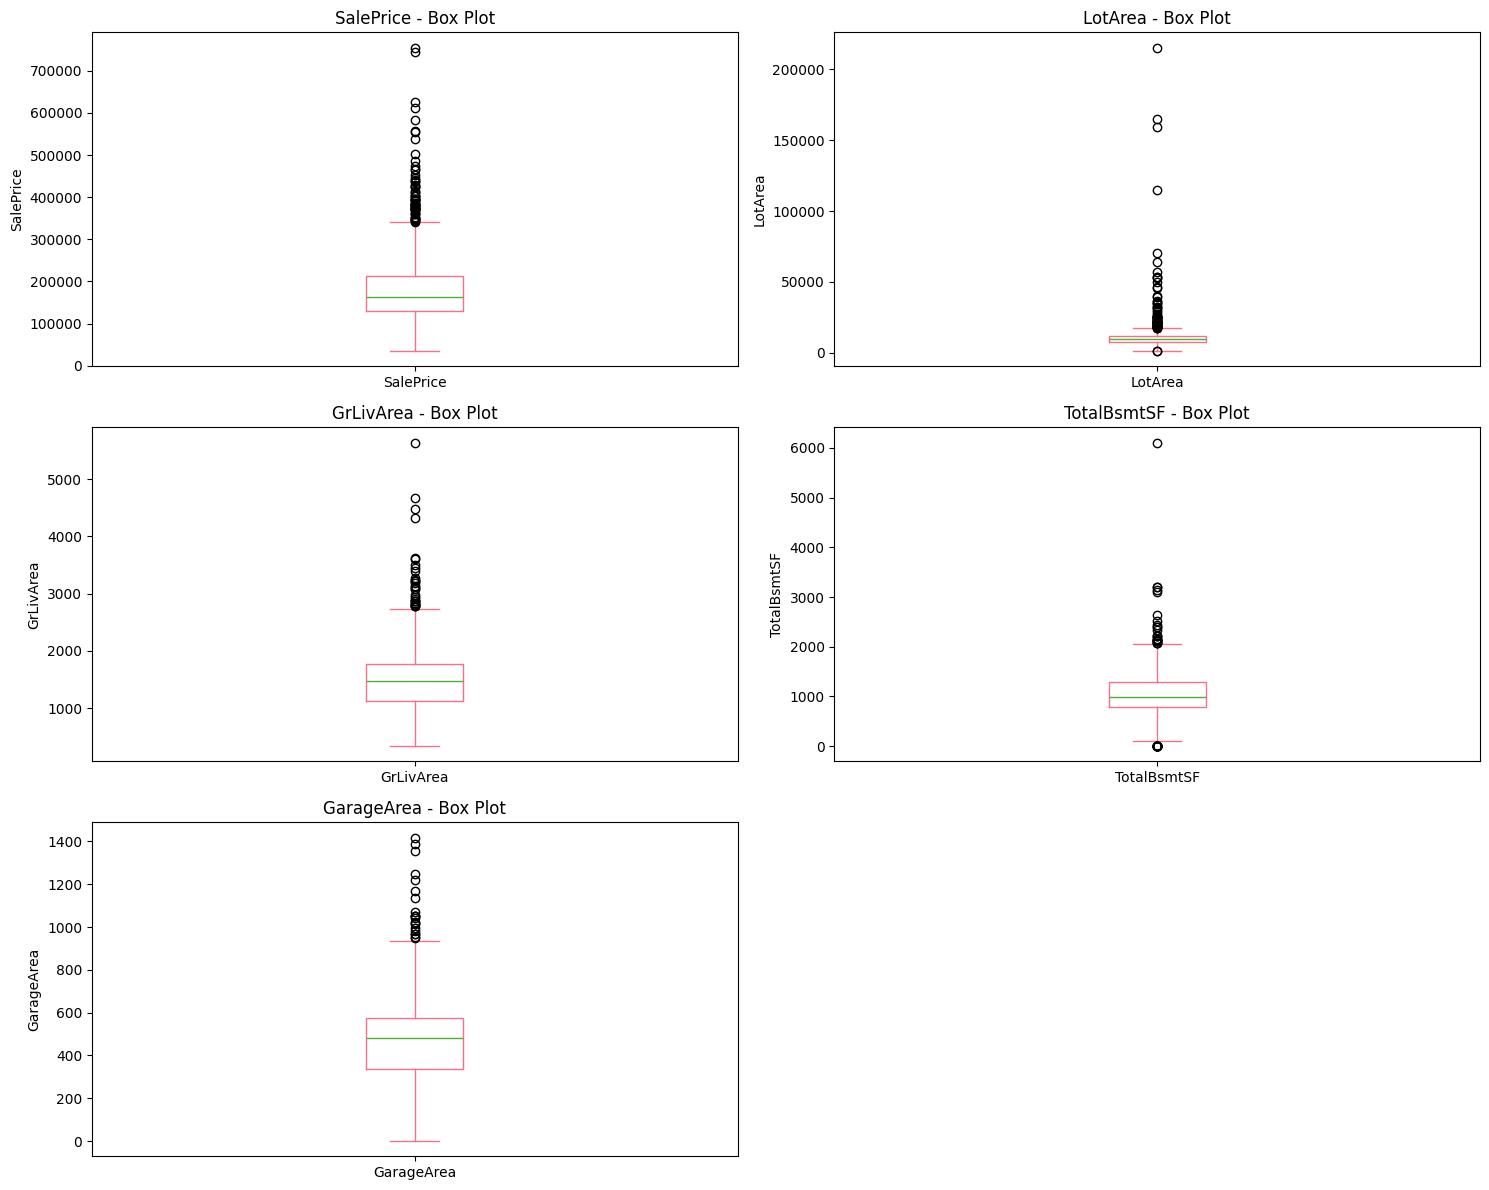

OUTLIER SUMMARY
SalePrice:
  - Outliers count: 61
  - Outliers percentage: 4.18%
  - Normal range: 3937.50 to 340037.50

LotArea:
  - Outliers count: 69
  - Outliers percentage: 4.73%
  - Normal range: 1481.50 to 17673.50

GrLivArea:
  - Outliers count: 31
  - Outliers percentage: 2.12%
  - Normal range: 158.62 to 2747.62

TotalBsmtSF:
  - Outliers count: 61
  - Outliers percentage: 4.18%
  - Normal range: 42.00 to 2052.00

GarageArea:
  - Outliers count: 21
  - Outliers percentage: 1.44%
  - Normal range: -27.75 to 938.25



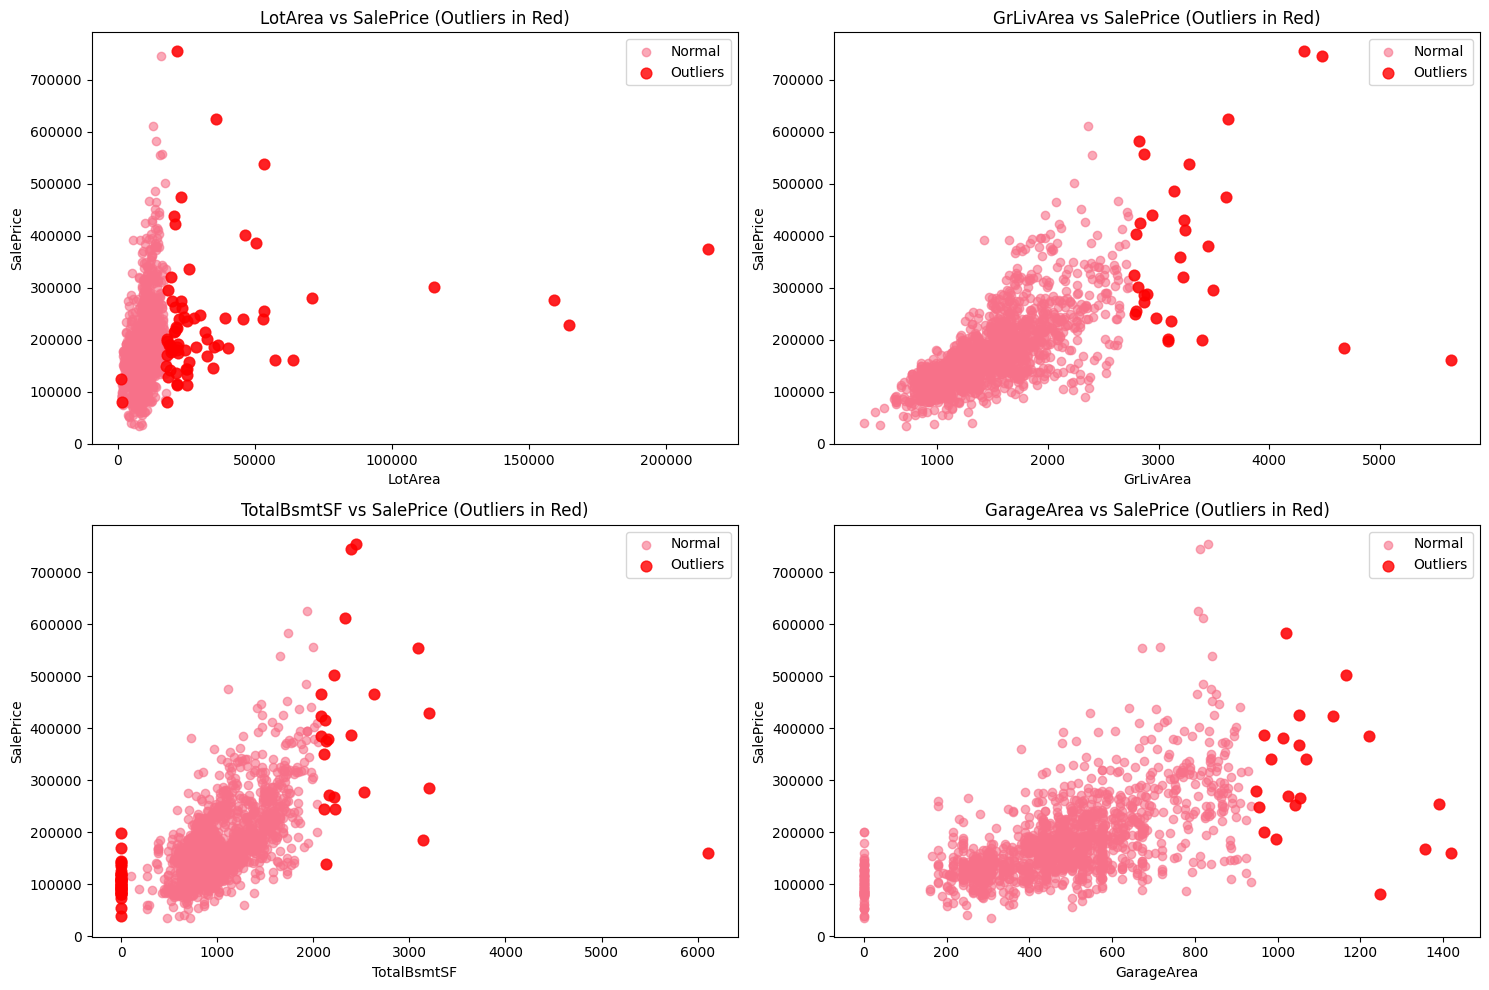

🏠 EXTREME PRICE OUTLIERS
Houses priced above $340,038:
        Id  SalePrice  GrLivArea Neighborhood  OverallQual
691    692     755000       4316      NoRidge           10
1182  1183     745000       4476      NoRidge           10
1169  1170     625000       3627      NoRidge           10
898    899     611657       2364      NridgHt            9
803    804     582933       2822      NridgHt            9
...    ...        ...        ...          ...          ...
990    991     348000       2392      NoRidge            8
642    643     345000       2704        NAmes            8
11      12     345000       2324      NridgHt            9
320    321     342643       2596      NridgHt            9
718    719     341000       2418      NoRidge            7

[61 rows x 5 columns]

Houses priced below $3,938:
Empty DataFrame
Columns: [Id, SalePrice, GrLivArea, Neighborhood, OverallQual]
Index: []

🚨 DATA QUALITY CHECKS
Checking for impossible values...
Houses built in the future: 0
Houses re

In [7]:
# Step 6: Outlier Detection
# Identifying unusual data points that might skew our model performance

print("🎯 OUTLIER DETECTION ANALYSIS")
print("=" * 50)

# Function to detect outliers using IQR method
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Check for outliers in target variable and key features
key_features_for_outliers = ['SalePrice', 'LotArea', 'GrLivArea', 'TotalBsmtSF', 'GarageArea']

outlier_summary = {}
plt.figure(figsize=(15, 12))

for i, feature in enumerate(key_features_for_outliers, 1):
    plt.subplot(3, 2, i)

    # Create box plot
    df[feature].plot(kind='box')
    plt.title(f'{feature} - Box Plot')
    plt.ylabel(feature)

    # Detect outliers
    outliers, lower, upper = detect_outliers_iqr(df, feature)
    outlier_summary[feature] = {
        'count': len(outliers),
        'percentage': len(outliers) / len(df) * 100,
        'lower_bound': lower,
        'upper_bound': upper
    }

plt.tight_layout()
plt.show()

# Print outlier summary
print("OUTLIER SUMMARY")
print("=" * 50)
for feature, stats in outlier_summary.items():
    print(f"{feature}:")
    print(f"  - Outliers count: {stats['count']}")
    print(f"  - Outliers percentage: {stats['percentage']:.2f}%")
    print(f"  - Normal range: {stats['lower_bound']:.2f} to {stats['upper_bound']:.2f}")
    print()

# Scatter plots to visualize outliers impact on SalePrice
plt.figure(figsize=(15, 10))
features_to_plot = ['LotArea', 'GrLivArea', 'TotalBsmtSF', 'GarageArea']

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)

    # Plot all points
    plt.scatter(df[feature], df['SalePrice'], alpha=0.6, label='Normal')

    # Highlight outliers
    outliers, _, _ = detect_outliers_iqr(df, feature)
    if len(outliers) > 0:
        plt.scatter(outliers[feature], outliers['SalePrice'],
                   color='red', s=60, alpha=0.8, label='Outliers')

    plt.xlabel(feature)
    plt.ylabel('SalePrice')
    plt.title(f'{feature} vs SalePrice (Outliers in Red)')
    plt.legend()

plt.tight_layout()
plt.show()

# Identify extreme outliers in SalePrice that might need special attention
price_outliers, price_lower, price_upper = detect_outliers_iqr(df, 'SalePrice')
print("🏠 EXTREME PRICE OUTLIERS")
print("=" * 50)
print(f"Houses priced above ${price_upper:,.0f}:")
expensive_houses = df[df['SalePrice'] > price_upper][['Id', 'SalePrice', 'GrLivArea', 'Neighborhood', 'OverallQual']]
print(expensive_houses.sort_values('SalePrice', ascending=False))
print()

print(f"Houses priced below ${price_lower:,.0f}:")
cheap_houses = df[df['SalePrice'] < price_lower][['Id', 'SalePrice', 'GrLivArea', 'Neighborhood', 'OverallQual']]
print(cheap_houses.sort_values('SalePrice'))

# Check for data entry errors (impossible values)
print("\n🚨 DATA QUALITY CHECKS")
print("=" * 50)
print("Checking for impossible values...")

# Year checks
print(f"Houses built in the future: {len(df[df['YearBuilt'] > 2024])}")
print(f"Houses remodeled before built: {len(df[df['YearRemodAdd'] < df['YearBuilt']])}")

# Area checks
print(f"Houses with 0 living area: {len(df[df['GrLivArea'] == 0])}")
print(f"Houses with negative values in any column: {(df.select_dtypes(include=[np.number]) < 0).any().sum()}")

📝 CATEGORICAL FEATURES ANALYSIS
Total categorical features: 43
Features: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

CATEGORICAL FEATURES BY CARDINALITY
Street:
  - Unique values: 2
  - Missing values: 0
  - Sample values: ['Pave', 'Grvl']

Alley:
  - Unique values: 2
  - Missing values: 1369
  - Sample values: ['Grvl', 'Pave']

Utilities:
  - Unique values: 2
  - Missing values: 0
  - Sample values: ['AllPub', 'NoSeWa']

CentralAir:
  - Unique values: 2
  - 

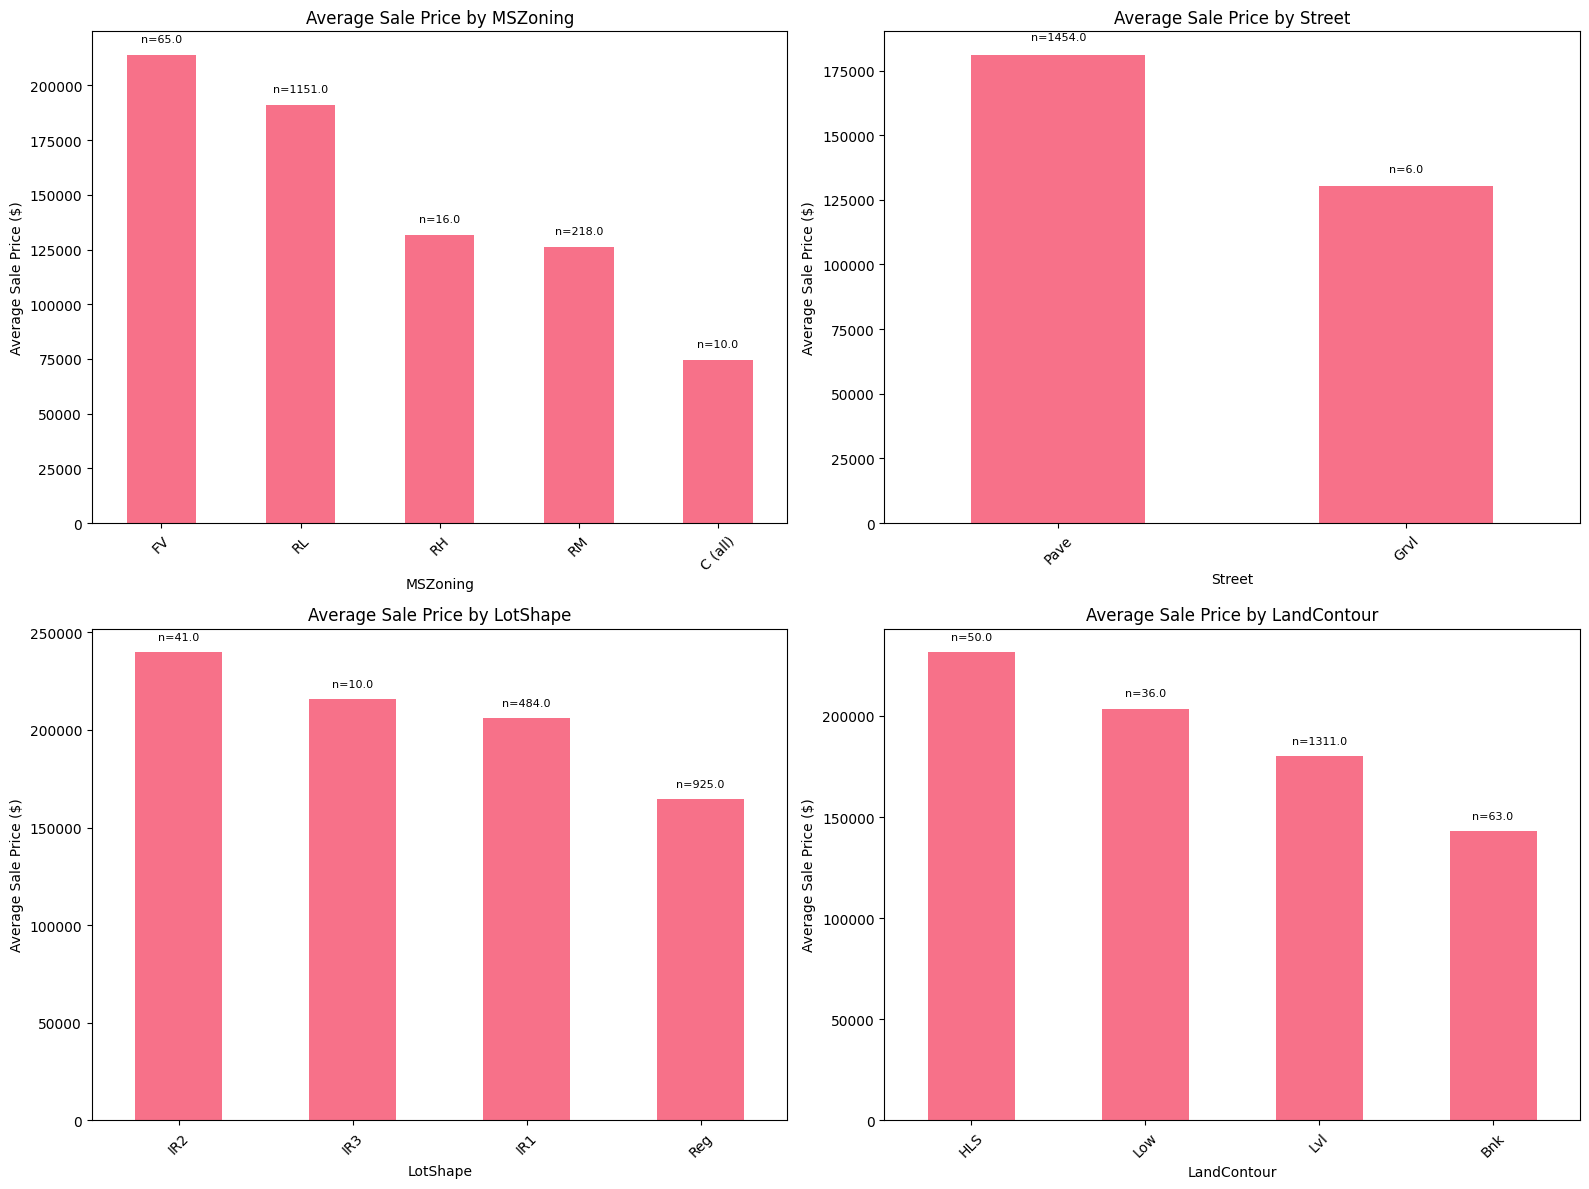

📊 CATEGORICAL FEATURES IMPACT ON PRICE
Top categorical features by price impact:
ExterQual:
  - Price range: $279,376
  - Impact score: 154.4%
  - Best category: Ex ($367,361)

RoofMatl:
  - Price range: $253,250
  - Impact score: 140.0%
  - Best category: WdShngl ($390,250)

Condition2:
  - Price range: $228,250
  - Impact score: 126.2%
  - Best category: PosA ($325,000)

KitchenQual:
  - Price range: $222,989
  - Impact score: 123.3%
  - Best category: Ex ($328,555)

Exterior2nd:
  - Price range: $214,000
  - Impact score: 118.3%
  - Best category: Other ($319,000)

BsmtQual:
  - Price range: $211,349
  - Impact score: 116.8%
  - Best category: Ex ($327,041)

FireplaceQu:
  - Price range: $207,948
  - Impact score: 114.9%
  - Best category: Ex ($337,712)

Exterior1st:
  - Price range: $191,000
  - Impact score: 105.6%
  - Best category: ImStucc ($262,000)

SaleCondition:
  - Price range: $168,167
  - Impact score: 93.0%
  - Best category: Partial ($272,292)

SaleType:
  - Price range

In [8]:
# Step 7: Categorical Features Analysis
# Understanding our categorical features and their relationship with house prices

print("📝 CATEGORICAL FEATURES ANALYSIS")
print("=" * 50)

# Get categorical features
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
print(f"Total categorical features: {len(categorical_features)}")
print(f"Features: {categorical_features}")
print()

# Analyze cardinality (number of unique values) in each categorical feature
cardinality_info = {}
for feature in categorical_features:
    unique_count = df[feature].nunique()
    cardinality_info[feature] = {
        'unique_count': unique_count,
        'sample_values': df[feature].dropna().unique()[:5].tolist(),
        'missing_count': df[feature].isnull().sum()
    }

# Sort by cardinality
sorted_cardinality = sorted(cardinality_info.items(), key=lambda x: x[1]['unique_count'])

print("CATEGORICAL FEATURES BY CARDINALITY")
print("=" * 50)
for feature, info in sorted_cardinality:
    print(f"{feature}:")
    print(f"  - Unique values: {info['unique_count']}")
    print(f"  - Missing values: {info['missing_count']}")
    print(f"  - Sample values: {info['sample_values']}")
    print()

# Analyze relationship between categorical features and SalePrice
# Focus on features with reasonable cardinality (2-20 categories)
moderate_cardinality_features = [feature for feature, info in cardinality_info.items()
                                if 2 <= info['unique_count'] <= 20 and info['missing_count'] < len(df) * 0.5]

print(f"Analyzing {len(moderate_cardinality_features)} features with moderate cardinality...")

# Create visualizations for top categorical features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

top_categorical = moderate_cardinality_features[:4]
for i, feature in enumerate(top_categorical):
    # Calculate average sale price by category
    avg_price_by_category = df.groupby(feature)['SalePrice'].agg(['mean', 'count']).sort_values('mean', ascending=False)

    # Plot
    avg_price_by_category['mean'].plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'Average Sale Price by {feature}')
    axes[i].set_ylabel('Average Sale Price ($)')
    axes[i].tick_params(axis='x', rotation=45)

    # Add count annotations
    for j, (category, row) in enumerate(avg_price_by_category.iterrows()):
        axes[i].text(j, row['mean'] + 5000, f"n={row['count']}",
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Statistical analysis of categorical features impact
print("📊 CATEGORICAL FEATURES IMPACT ON PRICE")
print("=" * 50)

categorical_impact = {}
for feature in moderate_cardinality_features:
    # Calculate price statistics by category
    price_by_category = df.groupby(feature)['SalePrice'].agg(['mean', 'std', 'count'])
    price_by_category = price_by_category.sort_values('mean', ascending=False)

    # Calculate coefficient of variation (price variability within categories)
    price_range = price_by_category['mean'].max() - price_by_category['mean'].min()
    overall_mean = df['SalePrice'].mean()
    impact_score = price_range / overall_mean * 100  # As percentage

    categorical_impact[feature] = {
        'price_range': price_range,
        'impact_score': impact_score,
        'categories': len(price_by_category),
        'top_category': price_by_category.index[0],
        'top_price': price_by_category['mean'].iloc[0]
    }

# Sort by impact score
sorted_impact = sorted(categorical_impact.items(), key=lambda x: x[1]['impact_score'], reverse=True)

print("Top categorical features by price impact:")
for feature, impact in sorted_impact[:10]:
    print(f"{feature}:")
    print(f"  - Price range: ${impact['price_range']:,.0f}")
    print(f"  - Impact score: {impact['impact_score']:.1f}%")
    print(f"  - Best category: {impact['top_category']} (${impact['top_price']:,.0f})")
    print()

# Analyze high-cardinality categorical features separately
high_cardinality_features = [feature for feature, info in cardinality_info.items()
                            if info['unique_count'] > 20]

if high_cardinality_features:
    print("⚠️ HIGH CARDINALITY FEATURES (might need special handling)")
    print("=" * 50)
    for feature in high_cardinality_features:
        info = cardinality_info[feature]
        print(f"{feature}: {info['unique_count']} unique values")
        # Show top categories by frequency
        top_categories = df[feature].value_counts().head(5)
        print(f"  Top categories: {dict(top_categories)}")
        print()

In [10]:
# Step 8: Handle Missing Values - Preprocessing
# Time to clean up our data and prepare it for modeling

print("🔧 HANDLING MISSING VALUES")
print("=" * 50)

# Make a copy of the original dataset for processing
df_processed = df.copy()
print(f"Starting with {df_processed.shape[0]} rows and {df_processed.shape[1]} columns")

# Analyze missing patterns more deeply first
missing_analysis = df_processed.isnull().sum().sort_values(ascending=False)
missing_features = missing_analysis[missing_analysis > 0]

print("Missing values strategy by feature type:")
print("=" * 40)

# Strategy 1: Features where NaN actually means "None" or "Not Applicable"
# Based on data description, these features have meaningful NaN values
none_features = {
    'PoolQC': 'No Pool',
    'MiscFeature': 'None',
    'Alley': 'No Alley',
    'Fence': 'No Fence',
    'FireplaceQu': 'No Fireplace',
    'GarageType': 'No Garage',
    'GarageFinish': 'No Garage',
    'GarageQual': 'No Garage',
    'GarageCond': 'No Garage',
    'BsmtQual': 'No Basement',
    'BsmtCond': 'No Basement',
    'BsmtExposure': 'No Basement',
    'BsmtFinType1': 'No Basement',
    'BsmtFinType2': 'No Basement',
    'MasVnrType': 'None'
}

print("1. Filling NaN with meaningful 'None' values:")
for feature, fill_value in none_features.items():
    if feature in df_processed.columns:
        before_count = df_processed[feature].isnull().sum()
        df_processed[feature].fillna(fill_value, inplace=True)
        print(f"   {feature}: {before_count} missing → filled with '{fill_value}'")

# Strategy 2: Numerical features where 0 makes sense for missing values
zero_features = {
    'GarageYrBlt': 0,  # No garage = year 0
    'GarageArea': 0,   # No garage = 0 area
    'GarageCars': 0,   # No garage = 0 cars
    'BsmtFinSF1': 0,   # No basement = 0 finished area
    'BsmtFinSF2': 0,   # No basement = 0 finished area
    'BsmtUnfSF': 0,    # No basement = 0 unfinished area
    'TotalBsmtSF': 0,  # No basement = 0 total area
    'BsmtFullBath': 0, # No basement = 0 full baths
    'BsmtHalfBath': 0, # No basement = 0 half baths
    'MasVnrArea': 0    # No masonry veneer = 0 area
}

print("\n2. Filling numerical NaN with 0 (where logical):")
for feature, fill_value in zero_features.items():
    if feature in df_processed.columns:
        before_count = df_processed[feature].isnull().sum()
        df_processed[feature].fillna(fill_value, inplace=True)
        print(f"   {feature}: {before_count} missing → filled with {fill_value}")

# Strategy 3: Use mode for remaining categorical features
print("\n3. Filling categorical features with mode:")
categorical_features = df_processed.select_dtypes(include=['object']).columns
for feature in categorical_features:
    if df_processed[feature].isnull().sum() > 0:
        mode_value = df_processed[feature].mode()[0] if len(df_processed[feature].mode()) > 0 else 'Unknown'
        before_count = df_processed[feature].isnull().sum()
        df_processed[feature].fillna(mode_value, inplace=True)
        print(f"   {feature}: {before_count} missing → filled with '{mode_value}'")

# Strategy 4: Use median for remaining numerical features
print("\n4. Filling numerical features with median:")
numerical_features = df_processed.select_dtypes(include=[np.number]).columns
for feature in numerical_features:
    if df_processed[feature].isnull().sum() > 0:
        median_value = df_processed[feature].median()
        before_count = df_processed[feature].isnull().sum()
        df_processed[feature].fillna(median_value, inplace=True)
        print(f"   {feature}: {before_count} missing → filled with {median_value}")

# Verify all missing values are handled
remaining_missing = df_processed.isnull().sum().sum()
print(f"\n✅ MISSING VALUES HANDLING COMPLETE!")
print(f"Remaining missing values: {remaining_missing}")

if remaining_missing == 0:
    print("🎉 Perfect! All missing values have been successfully handled.")
else:
    print(f"⚠️ Warning: {remaining_missing} missing values still remain.")
    remaining_features = df_processed.isnull().sum()
    remaining_features = remaining_features[remaining_features > 0]
    print("Features still with missing values:")
    print(remaining_features)

print(f"\nDataset shape after missing value handling: {df_processed.shape}")
print("Ready for feature encoding! 🚀")

🔧 HANDLING MISSING VALUES
Starting with 1460 rows and 81 columns
Missing values strategy by feature type:
1. Filling NaN with meaningful 'None' values:
   PoolQC: 1453 missing → filled with 'No Pool'
   MiscFeature: 1406 missing → filled with 'None'
   Alley: 1369 missing → filled with 'No Alley'
   Fence: 1179 missing → filled with 'No Fence'
   FireplaceQu: 690 missing → filled with 'No Fireplace'
   GarageType: 81 missing → filled with 'No Garage'
   GarageFinish: 81 missing → filled with 'No Garage'
   GarageQual: 81 missing → filled with 'No Garage'
   GarageCond: 81 missing → filled with 'No Garage'
   BsmtQual: 37 missing → filled with 'No Basement'
   BsmtCond: 37 missing → filled with 'No Basement'
   BsmtExposure: 38 missing → filled with 'No Basement'
   BsmtFinType1: 37 missing → filled with 'No Basement'
   BsmtFinType2: 38 missing → filled with 'No Basement'
   MasVnrType: 872 missing → filled with 'None'

2. Filling numerical NaN with 0 (where logical):
   GarageYrBlt: 8

In [11]:
# Step 9: Feature Encoding
# Convert categorical variables to numerical format for XGBoost

print("Feature Encoding Process")
print("=" * 40)

# Separate features and target
X = df_processed.drop(['Id', 'SalePrice'], axis=1)
y = df_processed['SalePrice']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"Categorical columns: {len(categorical_cols)}")
print(f"Numerical columns: {len(numerical_cols)}")

# Apply label encoding to categorical variables
# XGBoost can handle label encoded categories well
label_encoders = {}
X_encoded = X.copy()

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
    label_encoders[col] = le

print(f"Label encoding completed for {len(categorical_cols)} categorical features")

# Check for any remaining non-numeric data
print(f"Data types after encoding:")
print(X_encoded.dtypes.value_counts())

# Verify no missing values remain
print(f"Missing values after encoding: {X_encoded.isnull().sum().sum()}")
print("Feature encoding complete")

Feature Encoding Process
Features shape: (1460, 79)
Target shape: (1460,)
Categorical columns: 43
Numerical columns: 36
Label encoding completed for 43 categorical features
Data types after encoding:
int64      76
float64     3
Name: count, dtype: int64
Missing values after encoding: 0
Feature encoding complete


In [12]:
# Step 10: Train-Validation-Test Split
# Split data into train/validation/test sets with 60/20/20 ratio

from sklearn.model_selection import train_test_split

# First split: separate out test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=None
)

# Second split: divide remaining into train (60%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2 of total
)

print("Data Split Summary")
print("=" * 40)
print(f"Total samples: {len(X_encoded)}")
print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X_encoded)*100:.1f}%)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X_encoded)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X_encoded)*100:.1f}%)")

# Check target distribution across splits
print("\nTarget variable statistics across splits:")
print(f"Train - Mean: ${y_train.mean():,.0f}, Std: ${y_train.std():,.0f}")
print(f"Validation - Mean: ${y_val.mean():,.0f}, Std: ${y_val.std():,.0f}")
print(f"Test - Mean: ${y_test.mean():,.0f}, Std: ${y_test.std():,.0f}")

# Store feature names for later use
feature_names = X_encoded.columns.tolist()
print(f"\nTotal features for modeling: {len(feature_names)}")
print("Train-validation-test split completed")

Data Split Summary
Total samples: 1460
Training set: 876 samples (60.0%)
Validation set: 292 samples (20.0%)
Test set: 292 samples (20.0%)

Target variable statistics across splits:
Train - Mean: $181,234, Std: $77,222
Validation - Mean: $182,064, Std: $77,518
Test - Mean: $178,840, Std: $87,731

Total features for modeling: 79
Train-validation-test split completed


In [13]:
# Step 11: Baseline XGBoost Model
# Create and evaluate baseline model with default parameters

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initialize baseline XGBoost model
baseline_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=100  # Start with moderate number of trees
)

# Train baseline model
print("Training baseline XGBoost model...")
baseline_model.fit(X_train, y_train)

# Make predictions on validation set
y_val_pred = baseline_model.predict(X_val)

# Calculate evaluation metrics
def calculate_metrics(y_true, y_pred, set_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"{set_name} Metrics:")
    print(f"  RMSE: ${rmse:,.0f}")
    print(f"  MAE: ${mae:,.0f}")
    print(f"  R²: {r2:.4f}")
    return rmse, mae, r2

# Evaluate baseline model
print("Baseline Model Performance")
print("=" * 40)

# Training performance
y_train_pred = baseline_model.predict(X_train)
train_rmse, train_mae, train_r2 = calculate_metrics(y_train, y_train_pred, "Training")

print()
# Validation performance
val_rmse, val_mae, val_r2 = calculate_metrics(y_val, y_val_pred, "Validation")

# Check for overfitting
print(f"\nOverfitting Analysis:")
print(f"RMSE difference (Val - Train): ${val_rmse - train_rmse:,.0f}")
print(f"R² difference (Train - Val): {train_r2 - val_r2:.4f}")

if val_rmse > train_rmse * 1.1:
    print("Potential overfitting detected")
else:
    print("No significant overfitting detected")

print("Baseline model training completed")

Training baseline XGBoost model...
Baseline Model Performance
Training Metrics:
  RMSE: $484
  MAE: $333
  R²: 1.0000

Validation Metrics:
  RMSE: $29,002
  MAE: $18,786
  R²: 0.8595

Overfitting Analysis:
RMSE difference (Val - Train): $28,519
R² difference (Train - Val): 0.1404
Potential overfitting detected
Baseline model training completed


In [14]:
# Step 12: Cross-Validation for Robust Evaluation
# Use k-fold cross-validation to get more reliable performance estimates

from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer

# Define RMSE scorer for cross-validation
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

# Set up cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on training data
print("Performing 5-fold cross-validation...")
cv_scores = cross_val_score(baseline_model, X_train, y_train, cv=kf, scoring=rmse_scorer, n_jobs=-1)

# Convert negative scores back to positive RMSE values
cv_rmse_scores = -cv_scores

print("Cross-Validation Results")
print("=" * 40)
print(f"RMSE scores for each fold: {[f'${score:,.0f}' for score in cv_rmse_scores]}")
print(f"Mean CV RMSE: ${cv_rmse_scores.mean():,.0f}")
print(f"Standard deviation: ${cv_rmse_scores.std():,.0f}")
print(f"95% confidence interval: ${cv_rmse_scores.mean() - 2*cv_rmse_scores.std():,.0f} to ${cv_rmse_scores.mean() + 2*cv_rmse_scores.std():,.0f}")

# Compare CV performance with validation performance
print(f"\nPerformance Comparison:")
print(f"Validation RMSE: ${val_rmse:,.0f}")
print(f"Cross-validation RMSE: ${cv_rmse_scores.mean():,.0f}")
print(f"Difference: ${abs(val_rmse - cv_rmse_scores.mean()):,.0f}")

# Store baseline results for comparison
baseline_results = {
    'train_rmse': train_rmse,
    'val_rmse': val_rmse,
    'cv_rmse': cv_rmse_scores.mean(),
    'cv_std': cv_rmse_scores.std(),
    'r2': val_r2
}

print("Cross-validation completed")

Performing 5-fold cross-validation...
Cross-Validation Results
RMSE scores for each fold: ['$30,184', '$27,102', '$22,154', '$52,076', '$27,000']
Mean CV RMSE: $31,703
Standard deviation: $10,506
95% confidence interval: $10,692 to $52,715

Performance Comparison:
Validation RMSE: $29,002
Cross-validation RMSE: $31,703
Difference: $2,701
Cross-validation completed


Feature Importance Analysis
Top 20 most important features:
         feature  importance
16   OverallQual    0.469392
60    GarageCars    0.141654
45     GrLivArea    0.043470
29      BsmtQual    0.029867
51  KitchenAbvGr    0.022465
40    CentralAir    0.020964
63    GarageCond    0.019581
42      1stFlrSF    0.019003
53  TotRmsAbvGrd    0.018608
55    Fireplaces    0.017697
7    LandContour    0.017307
57    GarageType    0.013991
37   TotalBsmtSF    0.012680
43      2ndFlrSF    0.011763
52   KitchenQual    0.011209
59  GarageFinish    0.010807
11  Neighborhood    0.010566
33    BsmtFinSF1    0.008869
18     YearBuilt    0.007125
31  BsmtExposure    0.006358


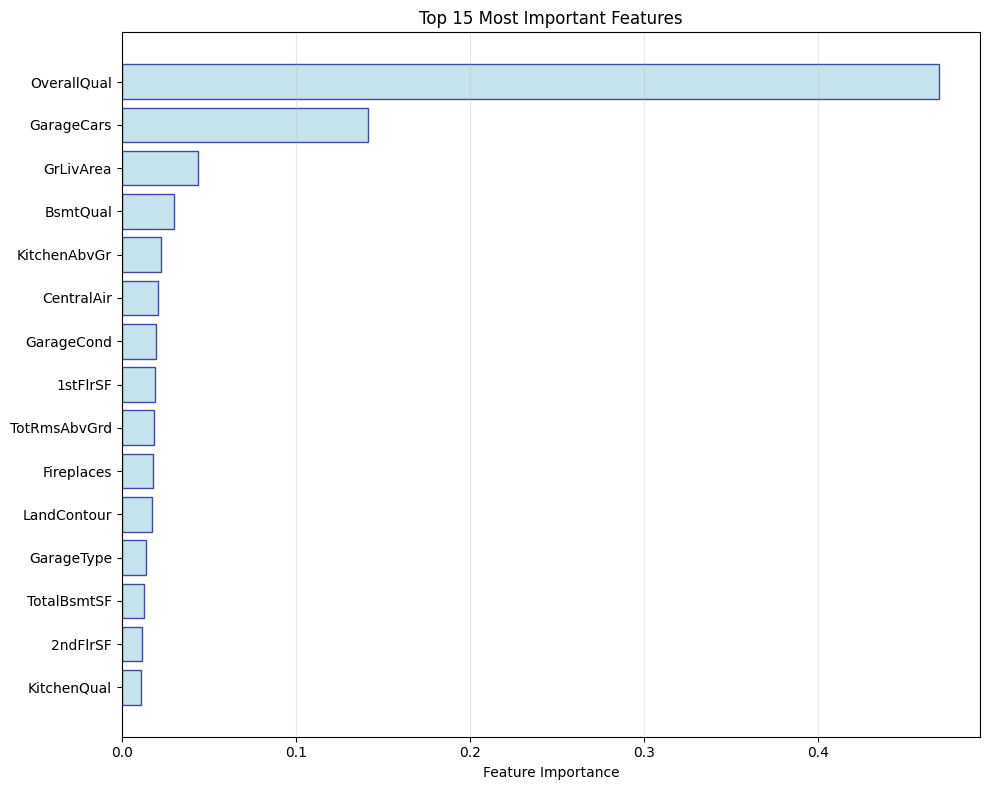


Features contributing to 90% of total importance: 18
These features could be used for feature selection in optimization

Feature Importance Statistics:
Maximum importance: 0.4694
Minimum importance: 0.0000
Mean importance: 0.0127
Features with zero importance: 5
Feature importance analysis completed


In [15]:
# Step 13: Feature Importance Analysis
# Analyze which features contribute most to the model's predictions

# Get feature importance from the baseline model
feature_importance = baseline_model.feature_importances_

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Feature Importance Analysis")
print("=" * 40)
print("Top 20 most important features:")
print(importance_df.head(20))

# Visualize top 15 features
plt.figure(figsize=(10, 8))
top_15_features = importance_df.head(15)
plt.barh(range(len(top_15_features)), top_15_features['importance'], color='lightblue', edgecolor='navy', alpha=0.7)
plt.yticks(range(len(top_15_features)), top_15_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate cumulative importance
importance_df['cumulative_importance'] = importance_df['importance'].cumsum()
total_importance = importance_df['importance'].sum()
importance_df['cumulative_percentage'] = (importance_df['cumulative_importance'] / total_importance) * 100

# Find features that contribute to 90% of total importance
features_90_percent = importance_df[importance_df['cumulative_percentage'] <= 90]
print(f"\nFeatures contributing to 90% of total importance: {len(features_90_percent)}")
print(f"These features could be used for feature selection in optimization")

# Show feature importance statistics
print(f"\nFeature Importance Statistics:")
print(f"Maximum importance: {importance_df['importance'].max():.4f}")
print(f"Minimum importance: {importance_df['importance'].min():.4f}")
print(f"Mean importance: {importance_df['importance'].mean():.4f}")
print(f"Features with zero importance: {sum(importance_df['importance'] == 0)}")

print("Feature importance analysis completed")

In [16]:
# Step 14: Hyperparameter Tuning with GridSearchCV
# Optimize XGBoost hyperparameters using grid search

from sklearn.model_selection import GridSearchCV

print("Starting hyperparameter tuning with GridSearchCV...")

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42
)

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=3,  # Use 3-fold CV for faster computation
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV (this will take some time)
print("Running grid search... This may take several minutes.")
grid_search.fit(X_train, y_train)

# Get best parameters and score
best_params = grid_search.best_params_
best_cv_score = -grid_search.best_score_  # Convert back to positive RMSE

print("\nGridSearchCV Results")
print("=" * 40)
print("Best parameters found:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation RMSE: ${best_cv_score:,.0f}")
print(f"Improvement over baseline CV: ${cv_rmse_scores.mean() - best_cv_score:,.0f}")

# Train best model on full training set
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Evaluate best model on validation set
y_val_pred_best = best_model.predict(X_val)
best_val_rmse, best_val_mae, best_val_r2 = calculate_metrics(y_val, y_val_pred_best, "Best Model Validation")

print(f"\nPerformance comparison:")
print(f"Baseline validation RMSE: ${val_rmse:,.0f}")
print(f"Tuned model validation RMSE: ${best_val_rmse:,.0f}")
print(f"Improvement: ${val_rmse - best_val_rmse:,.0f}")

print("GridSearchCV hyperparameter tuning completed")

Starting hyperparameter tuning with GridSearchCV...
Running grid search... This may take several minutes.
Fitting 3 folds for each of 324 candidates, totalling 972 fits

GridSearchCV Results
Best parameters found:
  colsample_bytree: 0.8
  learning_rate: 0.1
  max_depth: 4
  n_estimators: 300
  subsample: 0.8

Best cross-validation RMSE: $28,986
Improvement over baseline CV: $2,717
Best Model Validation Metrics:
  RMSE: $25,584
  MAE: $15,854
  R²: 0.8907

Performance comparison:
Baseline validation RMSE: $29,002
Tuned model validation RMSE: $25,584
Improvement: $3,419
GridSearchCV hyperparameter tuning completed


In [17]:
# Step 15: Advanced Optimization with Optuna
# Use Optuna for more sophisticated hyperparameter optimization

# Install optuna if not available
try:
    import optuna
except ImportError:
    print("Installing optuna...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "optuna"])
    import optuna

from optuna.samplers import TPESampler

print("Starting advanced hyperparameter tuning with Optuna...")

def objective(trial):
    # Define hyperparameter search space
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    # Create model with suggested parameters
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        **params
    )

    # Perform cross-validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring=rmse_scorer, n_jobs=-1)

    # Return mean CV score (Optuna minimizes by default)
    return -cv_scores.mean()

# Create Optuna study
study = optuna.create_study(
    direction='minimize',
    sampler=TPESampler(seed=42)
)

# Run optimization
print("Running Optuna optimization... This may take several minutes.")
study.optimize(objective, n_trials=50, timeout=600)  # 50 trials or 10 minutes max

# Get best parameters
best_optuna_params = study.best_params
best_optuna_score = -study.best_value

print("\nOptuna Optimization Results")
print("=" * 40)
print("Best parameters found:")
for param, value in best_optuna_params.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation RMSE: ${best_optuna_score:,.0f}")
print(f"Number of trials completed: {len(study.trials)}")

# Train final model with best parameters
final_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    **best_optuna_params
)

final_model.fit(X_train, y_train)

# Evaluate final model
y_val_pred_final = final_model.predict(X_val)
final_val_rmse, final_val_mae, final_val_r2 = calculate_metrics(y_val, y_val_pred_final, "Final Model Validation")

print(f"\nModel Performance Comparison:")
print(f"Baseline RMSE: ${val_rmse:,.0f}")
print(f"GridSearch RMSE: ${best_val_rmse:,.0f}")
print(f"Optuna RMSE: ${final_val_rmse:,.0f}")

print("Optuna optimization completed")

Installing optuna...


[I 2025-08-21 18:55:33,007] A new study created in memory with name: no-name-6f65cd89-cbc1-48cd-a010-365f8c70b6f9


Starting advanced hyperparameter tuning with Optuna...
Running Optuna optimization... This may take several minutes.


[I 2025-08-21 18:55:33,744] Trial 0 finished with value: 32355.852009862254 and parameters: {'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.22227824312530747, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'reg_alpha': 1.5599452033620265, 'reg_lambda': 0.5808361216819946, 'min_child_weight': 9}. Best is trial 0 with value: 32355.852009862254.
[I 2025-08-21 18:55:36,777] Trial 1 finished with value: 30886.017438845825 and parameters: {'n_estimators': 341, 'max_depth': 7, 'learning_rate': 0.01596950334578271, 'subsample': 0.9879639408647978, 'colsample_bytree': 0.9329770563201687, 'reg_alpha': 2.1233911067827616, 'reg_lambda': 1.8182496720710062, 'min_child_weight': 2}. Best is trial 1 with value: 30886.017438845825.
[I 2025-08-21 18:55:37,807] Trial 2 finished with value: 31567.59047438596 and parameters: {'n_estimators': 222, 'max_depth': 6, 'learning_rate': 0.13526405540621358, 'subsample': 0.7164916560792167, 'colsample_bytree': 0.8447411578889518, 


Optuna Optimization Results
Best parameters found:
  n_estimators: 494
  max_depth: 4
  learning_rate: 0.02223732605268196
  subsample: 0.7418463918804616
  colsample_bytree: 0.6002958901098486
  reg_alpha: 6.6410877993483375
  reg_lambda: 4.531075679238506
  min_child_weight: 7

Best cross-validation RMSE: $-29,192
Number of trials completed: 50
Final Model Validation Metrics:
  RMSE: $26,681
  MAE: $15,992
  R²: 0.8811

Model Performance Comparison:
Baseline RMSE: $29,002
GridSearch RMSE: $25,584
Optuna RMSE: $26,681
Optuna optimization completed


Final Model Evaluation on Test Set
Test Set Metrics:
  RMSE: $29,393
  MAE: $16,738
  R²: 0.8874

Complete Results Summary:
   Dataset          RMSE       R²
  Training  13622.520765 0.968845
Validation  26681.375677 0.881121
 Cross-Val -29191.958578      NaN
      Test  29393.250926 0.887363


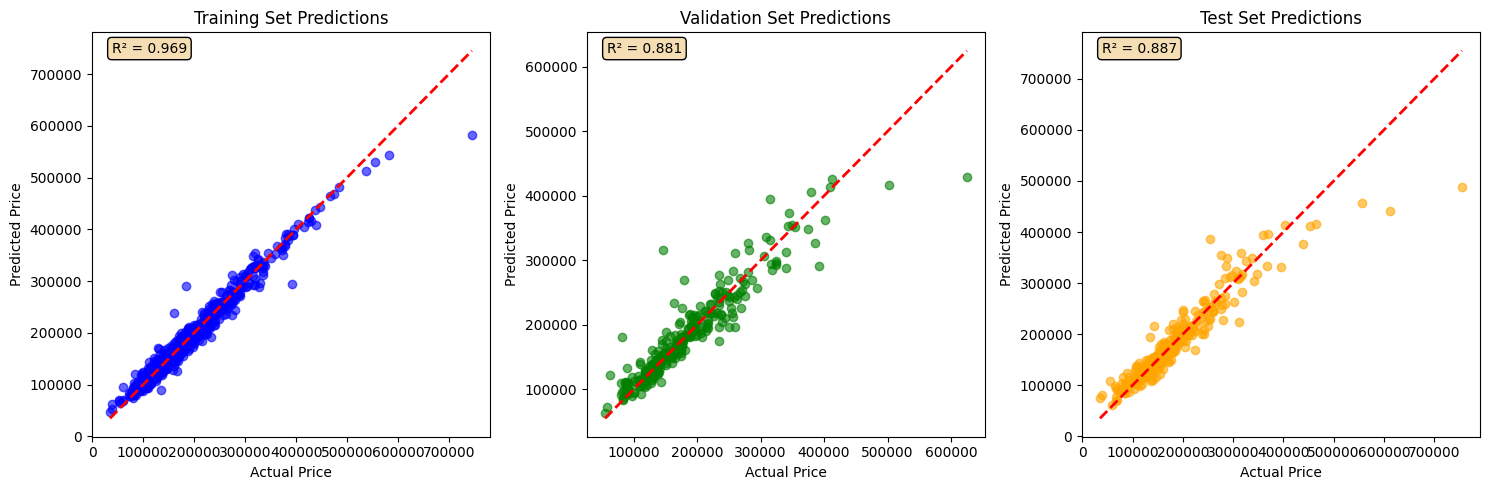

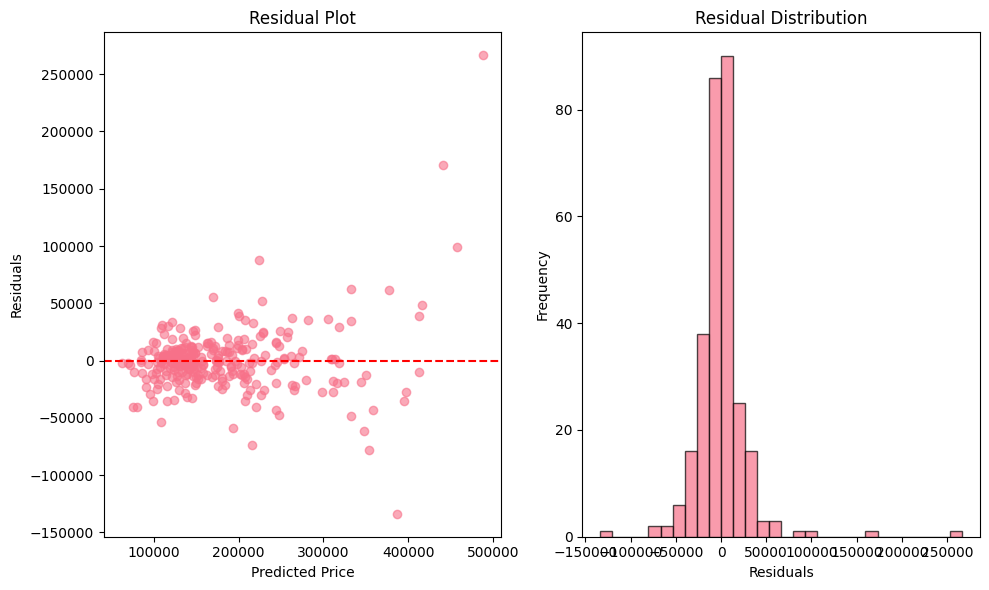

Final evaluation completed
Model is ready for deployment with test RMSE of $29,393


In [18]:
# Step 16: Final Model Evaluation on Test Set
# Evaluate the best model on the held-out test set

print("Final Model Evaluation on Test Set")
print("=" * 40)

# Make predictions on test set
y_test_pred = final_model.predict(X_test)

# Calculate test set metrics
test_rmse, test_mae, test_r2 = calculate_metrics(y_test, y_test_pred, "Test Set")

# Create comprehensive results summary
results_summary = pd.DataFrame({
    'Dataset': ['Training', 'Validation', 'Cross-Val', 'Test'],
    'RMSE': [
        np.sqrt(mean_squared_error(y_train, final_model.predict(X_train))),
        final_val_rmse,
        best_optuna_score,
        test_rmse
    ],
    'R²': [
        r2_score(y_train, final_model.predict(X_train)),
        final_val_r2,
        None,  # R² not calculated for CV
        test_r2
    ]
})

print("\nComplete Results Summary:")
print(results_summary.to_string(index=False))

# Visualize predictions vs actual values
plt.figure(figsize=(15, 5))

# Training set
plt.subplot(1, 3, 1)
y_train_pred_final = final_model.predict(X_train)
plt.scatter(y_train, y_train_pred_final, alpha=0.6, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Training Set Predictions')
plt.text(0.05, 0.95, f'R² = {r2_score(y_train, y_train_pred_final):.3f}',
         transform=plt.gca().transAxes, bbox=dict(boxstyle='round', facecolor='wheat'))

# Validation set
plt.subplot(1, 3, 2)
plt.scatter(y_val, y_val_pred_final, alpha=0.6, color='green')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Validation Set Predictions')
plt.text(0.05, 0.95, f'R² = {final_val_r2:.3f}',
         transform=plt.gca().transAxes, bbox=dict(boxstyle='round', facecolor='wheat'))

# Test set
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_test_pred, alpha=0.6, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Test Set Predictions')
plt.text(0.05, 0.95, f'R² = {test_r2:.3f}',
         transform=plt.gca().transAxes, bbox=dict(boxstyle='round', facecolor='wheat'))

plt.tight_layout()
plt.show()

# Residual analysis
plt.figure(figsize=(10, 6))
residuals = y_test - y_test_pred
plt.subplot(1, 2, 1)
plt.scatter(y_test_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution')

plt.tight_layout()
plt.show()

print("Final evaluation completed")
print(f"Model is ready for deployment with test RMSE of ${test_rmse:,.0f}")